# Loading and Preprocessing Data with TensorFlow

- When dealing with "**big data**" you will need TensorFlow's own data loading and preprocessing API: `tf.data`

    - Loading and preprocessing data extremely efficiently
    - Reading from multiple files in parallel using multithreading and queuing
    - Loading & preprocessing data batches across multiple CPU cores, while the GPUs are busy training



- In summary, `tf.data` handles **datasets that don't fit in memory**.

  - text files (such as CSV files)
  - binary files with fixed-size records
  - binary files that use TensorFlow's `TFRecord` format, which supports records of varying sizes.
  - support for reading from SQL databases
  - Google's BigQuery and other serverless data sources
  

### Setup

This project requires Python 3.7 or above:

In [3]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [4]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

And TensorFlow ≥ 2.8:

In [5]:
import tensorflow as tf

#assert version.parse(tf.__version__) >= version.parse("2.8.0")

# The tf.data API

The whole `tf.data` API revolves around the concept of a `tf.data.Dataset`:

- A `tf.data.Dataset` represents a sequence of data items.
- Usually you will use datasets that gradually read data from disk

- **Example dataset** from a simple data tensor using `tf.data.Dataset.from_tensor_slices()`:

In [6]:
import tensorflow as tf

X = tf.range(10)  # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)   # class method
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

`from_tensor_slices()` takes a tensor and creates a `tf.data.Dataset` whose elements are all the slices of X along the first dimension.

  - `tf.data.Dataset.range(10)` gives similar result

- `tf.data.Dataset`'s are iterable:

In [ ]:
for item in dataset:
  print(item)

The `tf.data API` is a **streaming API**: you can very efficiently iterate through a dataset's items, but the API is not designed for indexing or slicing.

In [14]:
# Sometimes this will give you the "size" of the dataset
dataset.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [10]:
dataset = dataset.repeat()

In [11]:
dataset.cardinality() == tf.data.INFINITE_CARDINALITY

<tf.Tensor: shape=(), dtype=bool, numpy=True>

- A dataset may also contain tuples of tensors, or dictionaries of name/tensor pairs.

- The dataset will only slice the tensors it contains, while preserving the tuple/dictionary structure.

In [15]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
  print(item)

{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=4>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=7>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=5>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=8>}
{'a': (<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=6>), 'b': <tf.Tensor: shape=(), dtype=int32, numpy=9>}


## Chaining Transformations

- You can apply all sorts of transformations to a Dataset by calling its **transformation methods**.

- Each method returns a new dataset, so you can chain transformations:

In [26]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(5).batch(4, drop_remainder=False)
for item in dataset:
  print(item)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9 0 1], shape=(4,), dtype=int32)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int32)
tf.Tensor([6 7 8 9], shape=(4,), dtype=int32)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9 0 1], shape=(4,), dtype=int32)
tf.Tensor([2 3 4 5], shape=(4,), dtype=int32)
tf.Tensor([6 7 8 9], shape=(4,), dtype=int32)
tf.Tensor([0 1 2 3], shape=(4,), dtype=int32)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int32)
tf.Tensor([8 9], shape=(2,), dtype=int32)


- `repeat(3)` returns a new dataset that repeats the items of the original dataset three times.

  - Of course, this will **not** copy all the data in memory three times!
  - If you call this method with no arguments, the new dataset will repeat the source dataset forever.

- `batch(7)` creates a new dataset that will group the items of the previous dataset in batches of seven items.

  - `drop_remainder=True` would drop the final batch

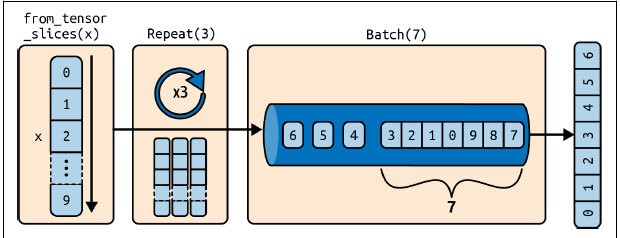

##### Transform Dataset items by calling the `map()` method

In [27]:
dataset = dataset.map(lambda x: x ** 2)  # x is a batch
for item in dataset:
  print(item)

tf.Tensor([0 1 4 9], shape=(4,), dtype=int32)
tf.Tensor([16 25 36 49], shape=(4,), dtype=int32)
tf.Tensor([64 81  0  1], shape=(4,), dtype=int32)
tf.Tensor([ 4  9 16 25], shape=(4,), dtype=int32)
tf.Tensor([36 49 64 81], shape=(4,), dtype=int32)
tf.Tensor([0 1 4 9], shape=(4,), dtype=int32)
tf.Tensor([16 25 36 49], shape=(4,), dtype=int32)
tf.Tensor([64 81  0  1], shape=(4,), dtype=int32)
tf.Tensor([ 4  9 16 25], shape=(4,), dtype=int32)
tf.Tensor([36 49 64 81], shape=(4,), dtype=int32)
tf.Tensor([0 1 4 9], shape=(4,), dtype=int32)
tf.Tensor([16 25 36 49], shape=(4,), dtype=int32)
tf.Tensor([64 81], shape=(2,), dtype=int32)


- `map()` is the method to call to apply any preprocessing to your data.

  - Sometimes this will include computations that can be quite intensive, so you will usually want to spawn multiple threads to
speed things up.
  - Set `num_parallel_calls` to the number of threads to run, or to `tf.data.AUTOTUNE`.
  

- It is also possible to simply filter the dataset using the `filter()` method

In [35]:
dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
  print(item)

tf.Tensor([16 25 36 49], shape=(4,), dtype=int32)
tf.Tensor([64 81  0  1], shape=(4,), dtype=int32)
tf.Tensor([ 4  9 16 25], shape=(4,), dtype=int32)
tf.Tensor([36 49 64 81], shape=(4,), dtype=int32)
tf.Tensor([16 25 36 49], shape=(4,), dtype=int32)
tf.Tensor([64 81  0  1], shape=(4,), dtype=int32)
tf.Tensor([ 4  9 16 25], shape=(4,), dtype=int32)
tf.Tensor([36 49 64 81], shape=(4,), dtype=int32)
tf.Tensor([16 25 36 49], shape=(4,), dtype=int32)
tf.Tensor([64 81], shape=(2,), dtype=int32)


- Look at just a few items from a dataset:

In [55]:
for item in dataset.take(2):
  print(item)

tf.Tensor([3 2 0 1 7 4 6], shape=(7,), dtype=int64)
tf.Tensor([9 1 5 2 8 0 3], shape=(7,), dtype=int64)


## Shuffling the Data

- Gradient descent works best when the instances in the training set are independent and identically distributed (IID).

- A simple way to ensure this is to shuffle the instances, using the `shuffle()` method.

  - It will create a new dataset that will start by filling up a **buffer** with the first items of the source dataset.

  - Then, whenever it is asked for an item, it will pull one out randomly from the buffer and replace it with a fresh one from the source dataset, until it has iterated entirely through the source dataset.

  - At this point it will continue to pull out items randomly from the buffer until it is empty.
  
- You must specify the buffer size, and it is important to make it large enough, or else shuffling will not be very effective.

- You can provide a random seed if you want the same random order every time you run your program.



In [63]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
  print(item)

tf.Tensor([1 4 2 3 5 0 6], shape=(7,), dtype=int64)
tf.Tensor([9 8 2 0 3 1 4], shape=(7,), dtype=int64)
tf.Tensor([5 7 9 6 7 8], shape=(6,), dtype=int64)


- For a large dataset that does not fit in memory, this simple shuffling-buffer approach
may not be sufficient, since the buffer will be small compared to the dataset.

- One solution is to shuffle the source data itself.

- Even if the source data is shuffled, you will usually want to shuffle it some more, or else the same order will be repeated at each epoch, and the model may end up being biased
(e.g., due to some spurious patterns present by chance in the source data's order).

- To shuffle the instances some more, a common approach is to split the source data into
multiple files, then read them in a random order during training.

  - To avoid instances located in the same file ending up close to each other, pick multiple files randomly and read them simultaneously, interleaving their records.
  - Then on top of that add a shuffling buffer using the `shuffle()` method.

### Interleaving lines from multiple files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set:

In [64]:
# fetches, splits and normalizes the California housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

- For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel.

- To demonstrate this, let's start by splitting the housing dataset and saving it to 20 CSV files:

In [65]:
# split the dataset into 20 parts and save it to CSV files
import numpy as np
from pathlib import Path

def save_to_csv_files(data, name_prefix, header=None, n_parts=10):
  housing_dir = Path() / "datasets" / "housing"
  housing_dir.mkdir(parents=True, exist_ok=True)
  filename_format = "my_{}_{:02d}.csv"

  filepaths = []
  m = len(data)
  chunks = np.array_split(np.arange(m), n_parts)
  for file_idx, row_indices in enumerate(chunks):
    part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
    filepaths.append(str(part_csv))
    with open(part_csv, "w") as f:
      if header is not None:
        f.write(header)
        f.write("\n")
      for row_idx in row_indices:
        f.write(",".join([repr(col) for col in data[row_idx]]))
        f.write("\n")
    print(f"Saved {part_csv}")
  return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(test_data, "test", header, n_parts=10)

Saved datasets\housing\my_train_00.csv
Saved datasets\housing\my_train_01.csv
Saved datasets\housing\my_train_02.csv
Saved datasets\housing\my_train_03.csv
Saved datasets\housing\my_train_04.csv
Saved datasets\housing\my_train_05.csv
Saved datasets\housing\my_train_06.csv
Saved datasets\housing\my_train_07.csv
Saved datasets\housing\my_train_08.csv
Saved datasets\housing\my_train_09.csv
Saved datasets\housing\my_train_10.csv
Saved datasets\housing\my_train_11.csv
Saved datasets\housing\my_train_12.csv
Saved datasets\housing\my_train_13.csv
Saved datasets\housing\my_train_14.csv
Saved datasets\housing\my_train_15.csv
Saved datasets\housing\my_train_16.csv
Saved datasets\housing\my_train_17.csv
Saved datasets\housing\my_train_18.csv
Saved datasets\housing\my_train_19.csv
Saved datasets\housing\my_valid_00.csv
Saved datasets\housing\my_valid_01.csv
Saved datasets\housing\my_valid_02.csv
Saved datasets\housing\my_valid_03.csv
Saved datasets\housing\my_valid_04.csv
Saved datasets\housing\my

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [66]:
print("".join(open(train_filepaths[0]).readlines()[:4]))

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621



In [67]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

**Building an Input Pipeline**

- A dataset containing only the filepaths:

In [68]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths,
                                              seed=42, shuffle=True)

In [85]:
# the file paths are automatically shuffled
for filepath in filepath_dataset:
  print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_18.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_13.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_11.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_14.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_06.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_17.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', sh

- `interleave()` reads from `cycle_length` files at a time and interleave their lines.



In [87]:
n_readers = 5
dataset = filepath_dataset.interleave(
    map_func=lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

- `interleave()` will create a dataset that will pull five filepaths from the filepath_dataset, and for each one it will call the function you gave it

  - The lambda will create a new dataset (in this case a `TextLineDataset`).
  
- When you iterate over the interleave dataset, it will cycle through these five `TextLineDatasets`,
reading one line at a time from each until all datasets are out of items.

- Then it will fetch the next five filepaths from the `filepath_dataset` and interleave them the
same way, and so on until it runs out of filepaths.

  - It is preferable to have files of identical length; otherwise the end of the longest file will not be interleaved.

- By default, `interleave()` does not use parallelism; it just reads one line at a time
from each file, sequentially.

- If you want it to actually read files in parallel, you can set the `num_parallel_calls` argument to the number of threads you want.

In [91]:
for line in dataset.take(5):
  print(line)

tf.Tensor(b'5.9522,26.0,6.196521739130435,1.0069565217391305,1479.0,2.5721739130434784,34.5,-119.75,4.384', shape=(), dtype=string)
tf.Tensor(b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625', shape=(), dtype=string)
tf.Tensor(b'3.0217,22.0,4.983870967741935,1.1008064516129032,615.0,2.4798387096774195,38.76,-120.6,1.069', shape=(), dtype=string)
tf.Tensor(b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159', shape=(), dtype=string)
tf.Tensor(b'2.1856,41.0,3.7189873417721517,1.0658227848101265,803.0,2.0329113924050635,32.76,-117.12,1.205', shape=(), dtype=string)


## Preprocessing the Data

- We need to do a bit of preprocessing, including parsing the strings and scaling the data.

In [92]:
# compute the mean and standard deviation of each feature
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_

- The `tf.io.decode_csv()` function takes two arguments: the first is the line to parse, and the second is an array containing the default value
for each column in the CSV file

  - `record_defaults` sets not only the default value for each column, but also the number of columns and their types

- `tf.stack()` stacks tensors into a 1D array

In [93]:
n_inputs = 8

def parse_csv_line(line):
  defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
  fields = tf.io.decode_csv(line, record_defaults=defs)
  return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
  x, y = parse_csv_line(line)
  return (x - X_mean) / X_std, y

In [97]:
preprocess(b'4.5909,16.0,5.475877192982456,1.0964912280701755,1357.0,2.9758771929824563,33.63,-117.71,2.418')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.36618188, -0.998705  ,  0.00781878, -0.00675364, -0.06140145,
         0.0072037 , -0.94465536,  0.9367464 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.418], dtype=float32)>)

## Putting Everything Together + Prefetching

Here is a helper function that creates and returns a dataset that will efficiently load California housing data from multiple CSV files, preprocess it, shuffle it, and batch it:

In [96]:
def csv_reader_dataset(filepaths,
                       n_readers=5,
                       n_read_threads=None,
                       n_parse_threads=5,
                       shuffle_buffer_size=10_000,
                       seed=42,
                       batch_size=32):
  dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
  dataset = dataset.interleave(
      lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
      cycle_length=n_readers, num_parallel_calls=n_read_threads)
  dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
  dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
  return dataset.batch(batch_size).prefetch(1)

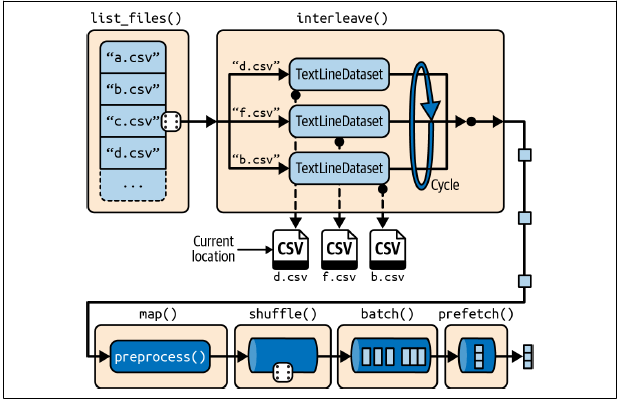

### Prefetching

- By calling `prefetch(1)` at the end of the custom `csv_reader_dataset()` function, we are creating a dataset that will do its best to always be one batch ahead.

- While our training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready (e.g., reading the data from disk and preprocessing it).


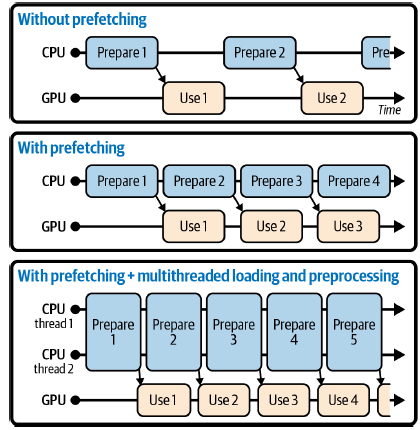

In [98]:
# show the first couple of batches produced by the dataset

example_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in example_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[-1.3957452  -0.04940685 -0.22830808  0.22648273  2.2593622   0.35200632
   0.9667386  -1.4121602 ]
 [ 2.7112627  -1.0778131   0.69413143 -0.14870553  0.51810503  0.3507294
  -0.82285154  0.80680597]
 [-0.13484643 -1.868895    0.01032507 -0.13787179 -0.12893449  0.03143518
   0.2687057   0.13212144]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.819]
 [3.674]
 [0.954]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[ 0.09031774  0.9789995   0.1327582  -0.13753782 -0.23388447  0.10211545
   0.97610843 -1.4121602 ]
 [ 0.05218809 -2.0271113   0.2940109  -0.02403445  0.16218767 -0.02844518
   1.4117942  -0.93737936]
 [-0.672276    0.02970133 -0.76922584 -0.15086786  0.4962024  -0.02741998
  -0.7853724   0.77182245]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[2.725]
 [1.205]
 [1.625]], shape=(3, 1), dtype=float32)



#### There are tons of other methods in the `Dataset` class:

In [99]:
def list_methods(module_=tf.data.Dataset):
  # list all methods of the tf.data.Dataset class
  for m in dir(module_):
    if not (m.startswith("_") or m.endswith("_")):
      func = getattr(module_, m)
      if hasattr(func, "__doc__"):
        print("● {:30s}{}".format(m + "()", func.__doc__.split("\n")[0]))

list_methods()

● apply()                       Applies a transformation function to this dataset.
● as_numpy_iterator()           Returns an iterator which converts all elements of the dataset to numpy.
● batch()                       Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()   A transformation that buckets elements in a `Dataset` by length.
● cache()                       Caches the elements in this dataset.
● cardinality()                 Returns the cardinality of the dataset, if known.
● choose_from_datasets()        Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()                 Creates a `Dataset` by concatenating the given dataset with this dataset.
● counter()                     Creates a `Dataset` that counts from `start` in steps of size `step`.
● element_spec()                The type specification of an element of this dataset.
● enumerate()                   Enumerates the elements of this dataset

In [40]:
# Plus a bunch of other stuff that is more "experimental"
list_methods(tf.data.experimental)

● AUTOTUNE()                    int([x]) -> integer
● AutoShardPolicy()             Represents the type of auto-sharding to use.
● AutotuneAlgorithm()           Represents the type of autotuning algorithm to use.
● AutotuneOptions()             Represents options for autotuning dataset performance.
● CheckpointInputPipelineHook() Checkpoints input pipeline state every N steps or seconds.
● Counter()                     Creates a `Dataset` that counts from `start` in steps of size `step`. (deprecated)
● CsvDataset()                  A Dataset comprising lines from one or more CSV files.
● DatasetInitializer()          Creates a table initializer from a `tf.data.Dataset`.
● DistributeOptions()           Represents options for distributed data processing.
● ExternalStatePolicy()         Represents how to handle external state during serialization.
● INFINITE_CARDINALITY()        int([x]) -> integer
● OptimizationOptions()         Represents options for dataset optimizations.
● Optional() 

## Using the Dataset with Keras

- Now we can use the custom `csv_reader_dataset()` function to create a dataset for the training set, the validation set and the test set.

In [100]:
train_set = csv_reader_dataset(train_filepaths)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [101]:
# for reproducibility
tf.keras.backend.clear_session()
tf.random.set_seed(42)

When you call the model's `fit()` method, you pass `train_set` instead of `X_train, y_train`,
and pass `validation_data=valid_set` instead of `validation_data=(X_valid, y_valid)`.

In [107]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=X_train.shape[1:]),
    tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1),
])
model.compile(loss="mse", optimizer="sgd")
model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.1487 - val_loss: 2.0094
Epoch 2/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5156 - val_loss: 0.5581
Epoch 3/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4875 - val_loss: 4.7682
Epoch 4/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4630 - val_loss: 8.7418
Epoch 5/5
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7518 - val_loss: 14.2336


Similarly, you can pass a dataset to the `evaluate()` and `predict()` methods:

In [108]:
test_mse = model.evaluate(test_set)
new_set = test_set.take(3)  # pretend we have 3 new samples
y_pred = model.predict(new_set)  # or you could just pass a NumPy array

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4702
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [109]:
# Example custom training loop

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.mean_squared_error

n_epochs = 5
for epoch in range(n_epochs):
  # Just iterate over dataset!
  for X_batch, y_batch in train_set:
    print("\rEpoch {}/{}".format(epoch + 1, n_epochs), end="")
    with tf.GradientTape() as tape:
      y_pred = model(X_batch)
      main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
      loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

AttributeError: module 'keras._tf_keras.keras.losses' has no attribute 'mean_squared_error'

# The TFRecord Format

- The `TFRecord` format is TensorFlow’s preferred format for storing large amounts of data and reading it efficiently.

- It is a very simple binary format that just contains a sequence of binary records of varying sizes.

  - Each record is comprised of a length, a
CRC checksum to check that the length was not corrupted, then the actual data, and
finally a CRC checksum for the data.



You can create one using a `tf.io.TFRecordWriter`:

In [110]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
  f.write(b"This is the first record")
  f.write(b"And this is the second record")

And you can read it using a `tf.data.TFRecordDataset`:

In [46]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
  print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [47]:
# read multiple files in parallel and interleave them

filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
  with tf.io.TFRecordWriter(filepath) as f:
    for j in range(3):
      f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
  print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## Compressed TFRecord Files

In [48]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
  f.write(b"Compress, compress, compress!")

In [49]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")

In [50]:
# the data is decompressed correctly
for item in dataset:
  print(item)

tf.Tensor(b'Compress, compress, compress!', shape=(), dtype=string)


## Protocol Buffers

- Each record can use **any** binary format you want.

- But `TFRecord` files usually contain serialized protocol buffers (*protobufs*).

  - Protobufs is a portable, extensible, and efficient binary format developed by Google.

  - They are defined using a simple language, then compiled.

First let's write a simple protobuf definition:

In [51]:
%%writefile person.proto
syntax = "proto3";
message Person {
    string name = 1;
    int32 id = 2;
    repeated string email = 3;
}

Writing person.proto


And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [52]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [53]:
%ls person*

person.desc  person_pb2.py  person.proto


In [54]:
from person_pb2 import Person  # import the generated access class

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [55]:
person.name  # read a field

'Al'

In [56]:
person.name = "Alice"  # modify a field

In [57]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [58]:
person.email.append("c@d.com")  # add an email address

In [59]:
serialized = person.SerializeToString()  # serialize person to a byte string
serialized

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [60]:
person2 = Person()  # create a new Person
person2.ParseFromString(serialized)  # parse the byte string (27 bytes long)

27

In [61]:
person == person2  # now they are equal

True

### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [62]:
# how to use the tf.io.decode_proto() function

person_tf = tf.io.decode_proto(
    bytes=serialized,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

## TensorFlow Protobufs

- The main protobuf typically used in a `TFRecord` file is the `Example` protobuf, which
represents one instance in a dataset.

- It contains a list of named features, where each
feature can either be a list of byte strings, a list of floats, or a list of integers.

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

Here is how you could create a `tf.train.Example` representing the same person as earlier:

In [63]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com",
                                                          b"c@d.com"]))
        }))

In [64]:
with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
  for _ in range(5):
    f.write(person_example.SerializeToString())

## Loading and Parsing Examples

In [65]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}

def parse(serialized_example):
  return tf.io.parse_single_example(serialized_example, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).map(parse)
for parsed_example in dataset:
  print(parsed_example)

{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0]
 [1]], shape=(2, 1), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([2], shape=(1,), dtype=int64)), 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>, 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}
{'emails': SparseTensor(indices=tf.Tenso

In [66]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [67]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [68]:
def parse(serialized_examples):
  return tf.io.parse_example(serialized_examples, feature_description)

dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(2).map(parse)
for parsed_examples in dataset:
  print(parsed_examples)  # two examples at a time

{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 0]
 [1 1]], shape=(4, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com' b'a@b.com' b'c@d.com'], shape=(4,), dtype=string), dense_shape=tf.Tensor([2 2], shape=(2,), dtype=int64)), 'id': <tf.Tensor: shape=(2,), dtype=int64, numpy=array([123, 123])>, 'name': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'Alice', b'Alice'], dtype=object)>}
{'emails': SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Ten

In [69]:
parsed_examples

{'emails': SparseTensor(indices=tf.Tensor(
 [[0 0]
  [0 1]], shape=(2, 2), dtype=int64), values=tf.Tensor([b'a@b.com' b'c@d.com'], shape=(2,), dtype=string), dense_shape=tf.Tensor([1 2], shape=(2,), dtype=int64)),
 'id': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([123])>,
 'name': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>}

## Storing Images and Tensors in TFRecords

Let's load and display an example image:

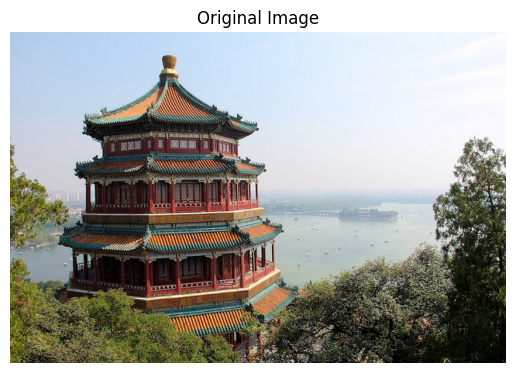

In [70]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

Now let's create an `Example` protobuf containing the image encoded as JPEG:

In [71]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
with tf.io.TFRecordWriter("my_image.tfrecord") as f:
  f.write(serialized_example)

Finally, let's create a tf.data pipeline that will read this TFRecord file, parse each `Example` protobuf (in this case just one), and parse and display the image that the example contains:

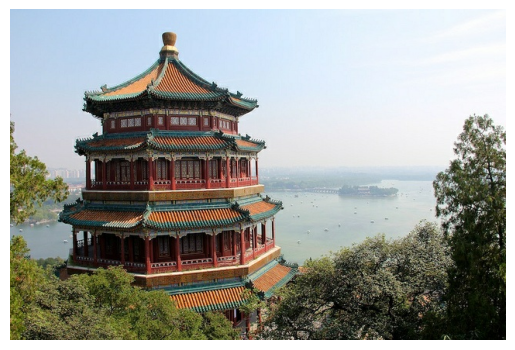

In [72]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }

def parse(serialized_example):
  example_with_image = tf.io.parse_single_example(serialized_example,
                                                  feature_description)
  return tf.io.decode_jpeg(example_with_image["image"].values[0])
  # or you can use tf.io.decode_image() instead

dataset = tf.data.TFRecordDataset("my_image.tfrecord").map(parse)
for image in dataset:
  plt.imshow(image)
  plt.axis("off")
  plt.show()

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [ ]:
tensor = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
serialized = tf.io.serialize_tensor(tensor)
serialized

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [ ]:
tf.io.parse_tensor(serialized, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [ ]:
sparse_tensor = parsed_example["emails"]
serialized_sparse = tf.io.serialize_sparse(sparse_tensor)
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [ ]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

# Keras Preprocessing Layers

- Preparing data for a neural network typically requires normalizing the numerical
features, encoding the categorical features and text, cropping and resizing images,
and more. There are several options for this:

1. The preprocessing can be done ahead of time when preparing your training data files, using any tools you like, such as NumPy, Pandas, or Scikit-Learn. You will need to apply the exact same preprocessing steps in production, to ensure your production model receives preprocessed inputs similar to the ones it was trained on.

2. Alternatively, you can preprocess your data on the fly while loading it with `tf.data`, by applying a preprocessing function to every element of a dataset using that dataset's `map()` method. Again, you will need to apply the same preprocessing steps in production.

3. One last approach is to include preprocessing layers directly inside your model so it can preprocess all the input data on the fly during training, then use the same preprocessing layers in production.

Keras offers many preprocessing layers that you can include in your models: they
can be applied to numerical features, categorical features, images, and text.

## The `Normalization` Layer

- Keras provides a `Normalization` layer that we can use to standardize the input features.

- We can either specify the mean and variance of each feature when creating the layer or pass the training set to the layer's `adapt()` method before fitting the model, so the layer can measure the feature means and variances on its own before training.

In [111]:
tf.random.set_seed(42)  #  ensures reproducibility
norm_layer = tf.keras.layers.Normalization()
model = tf.keras.models.Sequential([
    norm_layer,
    tf.keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
norm_layer.adapt(X_train)  # computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.7796 - val_loss: 0.8098
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7730 - val_loss: 0.6680
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6085 - val_loss: 0.6380
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5895 - val_loss: 0.6349
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5813 - val_loss: 0.6271


Since we included the `Normalization` layer inside the model, we can now deploy this model to production without having to worry about normalization again: the model
will just handle it.




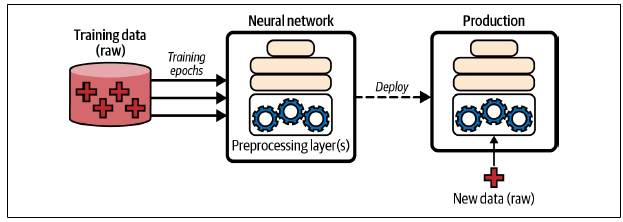

In [74]:
# Avoid training delays by normalizing the whole training set just once before training
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train)
X_valid_scaled = norm_layer(X_valid)

In [75]:
tf.random.set_seed(42)  # ensures reproducibility
model = tf.keras.models.Sequential([tf.keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
363/363 [==============================] - 2s 3ms/step - loss: 2.2985 - val_loss: 1.3217
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.8221 - val_loss: 1.7286
Epoch 3/5
363/363 [==============================] - 1s 3ms/step - loss: 0.7097 - val_loss: 1.3178
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6703 - val_loss: 0.8991
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.6433 - val_loss: 0.6146


In [ ]:
# Now we create a new model that includes the normalization layer

final_model = tf.keras.Sequential([norm_layer, model])
X_new = X_test[:3]  # pretend we have a few new instances (unscaled)
y_pred = final_model(X_new)  # preprocesses the data and makes predictions

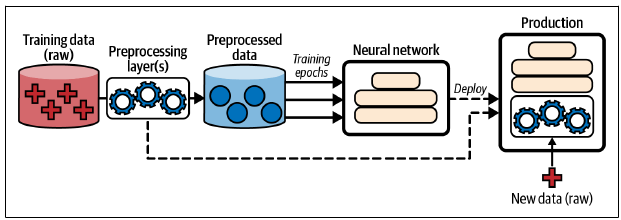

## The `Discretization` Layer

- The `Discretization` layer's goal is to transform a numerical feature into a categorical
feature by mapping value ranges (called bins) to categories.

- This is sometimes useful for features with multimodal distributions, or with features that have a highly nonlinear relationship with the target.

In [77]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = tf.keras.layers.Discretization(bin_boundaries=[18., 50.])
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

In [ ]:
discretize_layer = tf.keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age)
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

## The `CategoryEncoding` Layer

- When there are only a few categories (e.g., less than a dozen or two), then one-hot encoding is often a good option.

- Keras provides the `CategoryEncoding` layer for this purpose.

In [78]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>

In [80]:
onehot_layer = tf.keras.layers.CategoryEncoding(num_tokens=3, output_mode="count")
onehot_layer(age_categories)

<tf.Tensor: shape=(6, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)>

## The `StringLookup` Layer

In [81]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[1],
       [3],
       [3],
       [0]])>

In [82]:
str_lookup_layer = tf.keras.layers.StringLookup(num_oov_indices=5)
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Foo"], ["Bar"], ["Baz"]])

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[5],
       [7],
       [4],
       [3],
       [4]])>

In [83]:
str_lookup_layer = tf.keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)>

In [84]:
# the IntegerLookup layer
ids = [123, 456, 789]
int_lookup_layer = tf.keras.layers.IntegerLookup()
int_lookup_layer.adapt(ids)
int_lookup_layer([[123], [456], [123], [111]])

<tf.Tensor: shape=(4, 1), dtype=int64, numpy=
array([[3],
       [2],
       [3],
       [0]])>

## Encoding Categorical Features Using Embeddings

- An embedding is a dense representation of some higher-dimensional data, such as a category, or a word in a vocabulary.

- If there are 50,000 possible categories, then
one-hot encoding would produce a 50,000-dimensional sparse vector (i.e., containing
mostly zeros).

- In contrast, an embedding would be a comparatively small dense vector; for example, with just 100 dimensions.

In [85]:
tf.random.set_seed(42)
embedding_layer = tf.keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[-8.1814826e-05,  3.7823472e-02],
       [-2.9059220e-02, -4.0240347e-02],
       [-8.1814826e-05,  3.7823472e-02]], dtype=float32)>

In [86]:
tf.random.set_seed(42)
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]
str_lookup_layer = tf.keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
lookup_and_embed = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[], dtype=tf.string),
    str_lookup_layer,
    tf.keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),
                              output_dim=2)
])
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 0.04019848, -0.03289322],
       [ 0.01544314, -0.04434208],
       [ 0.04019848, -0.03289322]], dtype=float32)>

## Text Preprocessing

In [ ]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = tf.keras.layers.TextVectorization()
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 4), dtype=int64, numpy=
array([[2, 1, 0, 0],
       [6, 2, 1, 2]])>

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(ragged=True)
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.RaggedTensor [[2, 1], [6, 2, 1, 2]]>

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["Be good!", "Question: be or be?"])

<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0.96725637, 0.6931472 , 0.        , 0.        , 0.        ,
        0.        ],
       [0.96725637, 1.3862944 , 0.        , 0.        , 0.        ,
        1.0986123 ]], dtype=float32)>

In [ ]:
2 * np.log(1 + 4 / (1 + 3))

1.3862943611198906

In [ ]:
1 * np.log(1 + 4 / (1 + 1))

1.0986122886681098

# Using Pretrained Language Model Components

In [ ]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2")
sentence_embeddings = hub_layer(tf.constant(["To be", "Not to be"]))
sentence_embeddings.numpy().round(2)

array([[-0.25,  0.28,  0.01,  0.1 ,  0.14,  0.16,  0.25,  0.02,  0.07,
         0.13, -0.19,  0.06, -0.04, -0.07,  0.  , -0.08, -0.14, -0.16,
         0.02, -0.24,  0.16, -0.16, -0.03,  0.03, -0.14,  0.03, -0.09,
        -0.04, -0.14, -0.19,  0.07,  0.15,  0.18, -0.23, -0.07, -0.08,
         0.01, -0.01,  0.09,  0.14, -0.03,  0.03,  0.08,  0.1 , -0.01,
        -0.03, -0.07, -0.1 ,  0.05,  0.31],
       [-0.2 ,  0.2 , -0.08,  0.02,  0.19,  0.05,  0.22, -0.09,  0.02,
         0.19, -0.02, -0.14, -0.2 , -0.04,  0.01, -0.07, -0.22, -0.1 ,
         0.16, -0.44,  0.31, -0.1 ,  0.23,  0.15, -0.05,  0.15, -0.13,
        -0.04, -0.08, -0.16, -0.1 ,  0.13,  0.13, -0.18, -0.04,  0.03,
        -0.1 , -0.07,  0.07,  0.03, -0.08,  0.02,  0.05,  0.07, -0.14,
        -0.1 , -0.18, -0.13, -0.04,  0.15]], dtype=float32)

## Image Preprocessing Layers

In [ ]:
from sklearn.datasets import load_sample_images

images = load_sample_images()["images"]
crop_image_layer = tf.keras.layers.CenterCrop(height=100, width=100)
cropped_images = crop_image_layer(images)

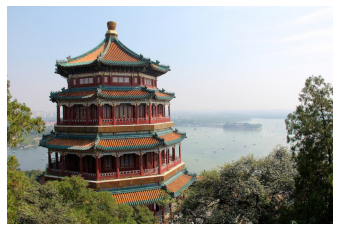

In [ ]:
plt.imshow(images[0])
plt.axis("off")
plt.show()

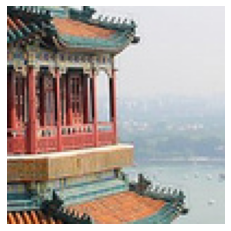

In [ ]:
plt.imshow(cropped_images[0] / 255)
plt.axis("off")
plt.show()

---
# Exercises

## 1. to 8.
1. Ingesting a large dataset and preprocessing it efficiently can be a complex engineering challenge. The Data API makes it fairly simple. It offers many features, including loading data from various sources (such as text or binary files), reading data in parallel from multiple sources, transforming it, interleaving the records, shuffling the data, batching it, and prefetching it.
2. Splitting a large dataset into multiple files makes it possible to shuffle it at a coarse level before shuffling it at a finer level using a shuffling buffer. It also makes it possible to handle huge datasets that do not fit on a single machine. It's also simpler to manipulate thousands of small files rather than one huge file; for example, it's easier to split the data into multiple subsets. Lastly, if the data is split across multiple files spread across multiple servers, it is possible to download several files from different servers simultaneously, which improves the bandwidth usage.
3. You can use TensorBoard to visualize profiling data: if the GPU is not fully utilized then your input pipeline is likely to be the bottleneck. You can fix it by making sure it reads and preprocesses the data in multiple threads in parallel, and ensuring it prefetches a few batches. If this is insufficient to get your GPU to 100% usage during training, make sure your preprocessing code is optimized. You can also try saving the dataset into multiple TFRecord files, and if necessary perform some of the preprocessing ahead of time so that it does not need to be done on the fly during training (TF Transform can help with this). If necessary, use a machine with more CPU and RAM, and ensure that the GPU bandwidth is large enough.
4. A TFRecord file is composed of a sequence of arbitrary binary records: you can store absolutely any binary data you want in each record. However, in practice most TFRecord files contain sequences of serialized protocol buffers. This makes it possible to benefit from the advantages of protocol buffers, such as the fact that they can be read easily across multiple platforms and languages and their definition can be updated later in a backward-compatible way.
5. The `Example` protobuf format has the advantage that TensorFlow provides some operations to parse it (the `tf.io.parse`*`example()` functions) without you having to define your own format. It is sufficiently flexible to represent instances in most datasets. However, if it does not cover your use case, you can define your own protocol buffer, compile it using `protoc` (setting the `--descriptor_set_out` and `--include_imports` arguments to export the protobuf descriptor), and use the `tf.io.decode_proto()` function to parse the serialized protobufs (see the "Custom protobuf" section of the notebook for an example). It's more complicated, and it requires deploying the descriptor along with the model, but it can be done.
6. When using TFRecords, you will generally want to activate compression if the TFRecord files will need to be downloaded by the training script, as compression will make files smaller and thus reduce download time. But if the files are located on the same machine as the training script, it's usually preferable to leave compression off, to avoid wasting CPU for decompression.
7. Let's look at the pros and cons of each preprocessing option:
    * If you preprocess the data when creating the data files, the training script will run faster, since it will not have to perform preprocessing on the fly. In some cases, the preprocessed data will also be much smaller than the original data, so you can save some space and speed up downloads. It may also be helpful to materialize the preprocessed data, for example to inspect it or archive it. However, this approach has a few cons. First, it's not easy to experiment with various preprocessing logics if you need to generate a preprocessed dataset for each variant. Second, if you want to perform data augmentation, you have to materialize many variants of your dataset, which will use a large amount of disk space and take a lot of time to generate. Lastly, the trained model will expect preprocessed data, so you will have to add preprocessing code in your application before it calls the model. There's a risk of code duplication and preprocessing mismatch in this case.
    * If the data is preprocessed with the tf.data pipeline, it's much easier to tweak the preprocessing logic and apply data augmentation. Also, tf.data makes it easy to build highly efficient preprocessing pipelines (e.g., with multithreading and prefetching). However, preprocessing the data this way will slow down training. Moreover, each training instance will be preprocessed once per epoch rather than just once if the data was preprocessed when creating the data files. Well, unless the dataset fits in RAM and you can cache it using the dataset's `cache()` method. Lastly, the trained model will still expect preprocessed data. But if you use preprocessing layers in your tf.data pipeline to handle the preprocessing step, then you can just reuse these layers in your final model (adding them after training), to avoid code duplication and preprocessing mismatch.
    * If you add preprocessing layers to your model, you will only have to write the preprocessing code once for both training and inference. If your model needs to be deployed to many different platforms, you will not need to write the preprocessing code multiple times. Plus, you will not run the risk of using the wrong preprocessing logic for your model, since it will be part of the model. On the downside, preprocessing the data on the fly during training will slow things down, and each instance will be preprocessed once per epoch.
8. Let's look at how to encode categorical text features and text:
    * To encode a categorical feature that has a natural order, such as a movie rating (e.g., "bad," "average," "good"), the simplest option is to use ordinal encoding: sort the categories in their natural order and map each category to its rank (e.g., "bad" maps to 0, "average" maps to 1, and "good" maps to 2). However, most categorical features don't have such a natural order. For example, there's no natural order for professions or countries. In this case, you can use one-hot encoding, or embeddings if there are many categories. With Keras, the `StringLookup` layer can be used for ordinal encoding (using the default `output_mode="int"`), or one-hot encoding (using `output_mode="one_hot"`). It can also perform multi-hot encoding (using `output_mode="multi_hot"`) if you want to encode multiple categorical text features together, assuming they share the same categories and it doesn't matter which feature contributed which category. For trainable embeddings, you must first use the `StringLookup` layer to produce an ordinal encoding, then use the `Embedding` layer.
    * For text, the `TextVectorization` layer is easy to use and it can work well for simple tasks, or you can use TF Text for more advanced features. However, you'll often want to use pretrained language models, which you can obtain using tools like TF Hub or Hugging Face's Transformers library. These last two options are discussed in Chapter 16.

## 9.
### a.
_Exercise: Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
tf.random.set_seed(42)
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.shuffle(len(X_train), seed=42)
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-02-20 15:27:32.431462: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [ ]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [ ]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [ ]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

### b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [ ]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [ ]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

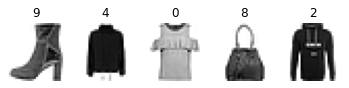

In [ ]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [ ]:
tf.random.set_seed(42)

standardization = tf.keras.layers.Normalization(input_shape=[28, 28])

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = tf.keras.Sequential([
    standardization,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [ ]:
from datetime import datetime

logs = Path() / "my_logs" / "run_" / datetime.now().strftime("%Y%m%d_%H%M%S")

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

2022-02-20 15:30:49.689831: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-02-20 15:30:49.689858: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-02-20 15:30:49.691427: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


Epoch 1/5
     59/Unknown - 1s 3ms/step - loss: 0.9230 - accuracy: 0.6817

2022-02-20 15:30:50.428921: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-02-20 15:30:50.428945: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-02-20 15:30:50.433359: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-02-20 15:30:50.446608: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-02-20 15:30:50.461272: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_/20220220_153049/plugins/profile/2022_02_20_15_30_50

2022-02-20 15:30:50.465450: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_logs/run_/20220220_153049/plugins/profile/2022_02_20_15_30_50/kiwimac.trace.json.gz
2022-02-20 15:30:50.480245: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_/20220220_153049/plugins/profile/2

1719/1719 [==============================] - 5s 2ms/step - loss: 0.4437 - accuracy: 0.8402 - val_loss: 0.3649 - val_accuracy: 0.8682
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3333 - accuracy: 0.8775 - val_loss: 0.3346 - val_accuracy: 0.8790
Epoch 3/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2970 - accuracy: 0.8905 - val_loss: 0.3235 - val_accuracy: 0.8866
Epoch 4/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2723 - accuracy: 0.8995 - val_loss: 0.3308 - val_accuracy: 0.8888
Epoch 5/5
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2534 - accuracy: 0.9047 - val_loss: 0.3174 - val_accuracy: 0.8916


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## 10.
_Exercise: In this exercise you will download a dataset, split it, create a `tf.data.Dataset` to load it and preprocess it efficiently, then build and train a binary classification model containing an `Embedding` layer._

### a.
_Exercise: Download the [Large Movie Review Dataset](https://homl.info/imdb), which contains 50,000 movies reviews from the [Internet Movie Database](https://imdb.com/). The data is organized in two directories, `train` and `test`, each containing a `pos` subdirectory with 12,500 positive reviews and a `neg` subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise._

In [ ]:
from pathlib import Path

root = "https://ai.stanford.edu/~amaas/data/sentiment/"
filename = "aclImdb_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename, root + filename, extract=True,
                                   cache_dir=".")
path = Path(filepath).with_name("aclImdb")
path

84140032/84125825 [==============================] - 27s 0us/step


PosixPath('datasets/aclImdb')

Let's define a `tree()` function to view the structure of the `aclImdb` directory:

In [ ]:
def tree(path, level=0, indent=4, max_files=3):
    if level == 0:
        print(f"{path}/")
        level += 1
    sub_paths = sorted(path.iterdir())
    sub_dirs = [sub_path for sub_path in sub_paths if sub_path.is_dir()]
    filepaths = [sub_path for sub_path in sub_paths if not sub_path in sub_dirs]
    indent_str = " " * indent * level
    for sub_dir in sub_dirs:
        print(f"{indent_str}{sub_dir.name}/")
        tree(sub_dir,  level + 1, indent)
    for filepath in filepaths[:max_files]:
        print(f"{indent_str}{filepath.name}")
    if len(filepaths) > max_files:
        print(f"{indent_str}...")

In [ ]:
tree(path)

datasets/aclImdb/
    test/
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
    train/
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
    README
    imdb.vocab
    imdbEr.txt


In [ ]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

### b.
_Exercise: Split the test set into a validation set (15,000) and a test set (10,000)._

In [ ]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

### c.
_Exercise: Use tf.data to create an efficient dataset for each set._

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [ ]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [ ]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b'Well...tremors I, the original started off in 1990 and i found the movie quite enjoyable to watch. however, they proceeded to make tremors II and III. Trust me, those movies started going downhill right after they finished the first one, i mean, ass blasters??? Now, only God himself is capable of answering the question "why in Gods name would they create another one of these dumpster dives of a movie?" Tremors IV cannot be considered a bad movie, in fact it cannot be even considered an epitome of a bad movie, for it lives up to more than that. As i attempted to sit though it, i noticed that my eyes started to bleed, and i hoped profusely that the little 

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

29.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It takes about 17 seconds to load the dataset and go through it 10 times.

But let's pretend the dataset does not fit in memory, just to make things more interesting. Luckily, each review fits on just one line (they use `<br />` to indicate line breaks), so we can read the reviews using a `TextLineDataset`. If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). For very large datasets, it would make sense to use a tool like Apache Beam for that.

In [ ]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

27.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now it takes about 33 seconds to go through the dataset 10 times. That's much slower, essentially because the dataset is not cached in RAM, so it must be reloaded at each epoch. If you add `.cache()` just before `.repeat(10)`, you will see that this implementation will be about as fast as the previous one.

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

20.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000, seed=42)
train_set = train_set.batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d.
_Exercise: Create a binary classification model, using a `TextVectorization` layer to preprocess each review._

Let's create a `TextVectorization` layer and adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`). Let's use TF-IDF for now.

In [ ]:
max_tokens = 1000
sample_reviews = train_set.map(lambda review, label: review)
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="tf_idf")
text_vectorization.adapt(sample_reviews)

Good! Now let's take a look at the first 10 words in the vocabulary:

In [ ]:
text_vectorization.get_vocabulary()[:10]

['[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i']

These are the most common words in the reviews.

We're ready to train the model!

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 4s 4ms/step - loss: 0.4521 - accuracy: 0.8189 - val_loss: 0.3894 - val_accuracy: 0.8419
Epoch 2/5
782/782 [==============================] - 4s 4ms/step - loss: 0.3608 - accuracy: 0.8537 - val_loss: 0.7081 - val_accuracy: 0.7643
Epoch 3/5
782/782 [==============================] - 4s 4ms/step - loss: 0.3123 - accuracy: 0.8742 - val_loss: 0.3367 - val_accuracy: 0.8569
Epoch 4/5
782/782 [==============================] - 4s 4ms/step - loss: 0.2535 - accuracy: 0.8968 - val_loss: 0.5343 - val_accuracy: 0.8040
Epoch 5/5
782/782 [==============================] - 4s 4ms/step - loss: 0.1879 - accuracy: 0.9274 - val_loss: 0.3888 - val_accuracy: 0.8439


We get about 84.2% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using `tf.data` and Keras preprocessing layers.

### e.
_Exercise: Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model._

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [ ]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the `<pad>` token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [ ]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [ ]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced TF-IDF with ordinal encoding (`output_mode="int"`) followed by an `Embedding` layer, followed by a `Lambda` layer that calls the `compute_mean_embedding` layer:

In [ ]:
embedding_size = 20
tf.random.set_seed(42)

text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens, output_mode="int")
text_vectorization.adapt(sample_reviews)

model = tf.keras.Sequential([
    text_vectorization,
    tf.keras.layers.Embedding(input_dim=max_tokens,
                              output_dim=embedding_size,
                              mask_zero=True),  # <pad> tokens => zero vectors
    tf.keras.layers.Lambda(compute_mean_embedding),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

### f.
_Exercise: Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible._

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 9s 10ms/step - loss: 0.4758 - accuracy: 0.7675 - val_loss: 0.4153 - val_accuracy: 0.8009
Epoch 2/5
782/782 [==============================] - 8s 9ms/step - loss: 0.3438 - accuracy: 0.8537 - val_loss: 0.3814 - val_accuracy: 0.8245
Epoch 3/5
782/782 [==============================] - 8s 10ms/step - loss: 0.3244 - accuracy: 0.8618 - val_loss: 0.3341 - val_accuracy: 0.8520
Epoch 4/5
782/782 [==============================] - 10s 11ms/step - loss: 0.3153 - accuracy: 0.8666 - val_loss: 0.3122 - val_accuracy: 0.8655
Epoch 5/5
782/782 [==============================] - 11s 12ms/step - loss: 0.3135 - accuracy: 0.8676 - val_loss: 0.3119 - val_accuracy: 0.8625


The model is just marginally better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).

### g.
_Exercise: Use TFDS to load the same dataset more easily: `tfds.load("imdb_reviews")`._

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [ ]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
